In [8]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import polars as pl
from flax import nnx
from jax import random
from numpyro.contrib.module import nnx_module

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [2]:
data_path = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/online_game_ate.csv"

raw_df = pl.read_csv(data_path)


columns_to_keep = [
    "Guild Membership",
    "Side-quest Engagement",
    "Won Items",
    "In-game Purchases",
]

df = raw_df[columns_to_keep]

df.head()

Guild Membership,Side-quest Engagement,Won Items,In-game Purchases
i64,i64,i64,f64
0,1,1,1030.29
0,1,0,2453.34
0,1,1,3761.4
1,1,1,1007.84
0,1,0,4153.94


In [19]:
in_game_purchases = df["In-game Purchases"].to_jax()

In [66]:
class Confounders2Engagement(nnx.Module):
    def __init__(
        self,
        input_dim: int = 1 + 1,
        output_dim: int = 1,
        hidden_dim: int = 5,
        *,
        rngs: nnx.Rngs,
    ) -> None:
        self.fc1 = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_engagement_ρ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        hidden = jax.nn.softplus(self.fc1(x))
        ρ_engagement = jax.nn.sigmoid(self.f_engagement_ρ(hidden))
        ρ_engagement = ρ_engagement.T.squeeze(0)
        return ρ_engagement


class PurchasesNetwork(nnx.Module):
    def __init__(
        self,
        input_dim=1 + 1 + 1,
        hidden_dim=5,
        *,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.f_hidden = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.f_purchase_μ = nnx.Linear(hidden_dim, 1, rngs=rngs)
        self.f_purchase_σ = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x: jax.Array) -> tuple[jax.Array, jax.Array]:
        hidden = jax.nn.softplus(self.f_hidden(x))
        μ_purchases = self.f_purchase_μ(hidden)
        σ_purchases = 1e-6 + jax.nn.softplus(self.f_purchase_σ(hidden))
        μ_purchases = μ_purchases.T.squeeze(0)
        σ_purchases = σ_purchases.T.squeeze(0)
        return μ_purchases, σ_purchases

In [67]:
rng_key, rng_subkey = random.split(rng_key)
nn_confounders_2_engagement = Confounders2Engagement(rngs=nnx.Rngs(rng_subkey))

rng_key, rng_subkey = random.split(rng_key)
nn_purchases_network = PurchasesNetwork(rngs=nnx.Rngs(rng_subkey))

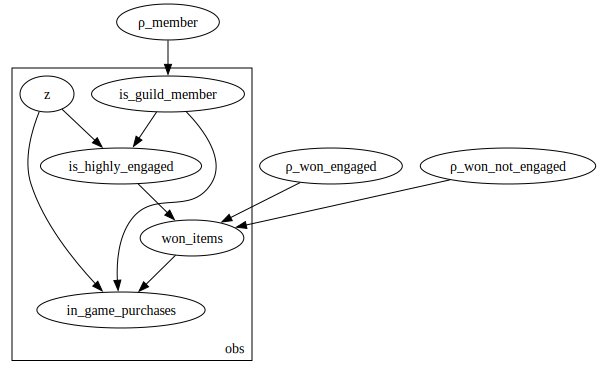

In [73]:
def model(in_game_purchases):
    n_obs = in_game_purchases.shape[0]

    ρ_member = numpyro.sample("ρ_member", dist.Beta(2, 5))

    ρ_won_engaged = numpyro.sample("ρ_won_engaged", dist.Beta(5, 2))
    ρ_won_not_engaged = numpyro.sample("ρ_won_not_engaged", dist.Beta(2, 5))

    with numpyro.plate("obs", n_obs):
        z = numpyro.sample("z", dist.Normal(0.0, 1.0))

        is_guild_member = numpyro.sample("is_guild_member", dist.Bernoulli(ρ_member))

        engagement_input = jnp.stack((is_guild_member, z)).T

        nnx_confounders_2_engagement = nnx_module(
            "nnx_confounders_2_engagement", nn_confounders_2_engagement
        )

        ρ_engagement = nnx_confounders_2_engagement(engagement_input)

        is_highly_engaged = numpyro.sample(
            "is_highly_engaged", dist.Bernoulli(ρ_engagement)
        )

        p_won = ρ_won_engaged * is_highly_engaged + ρ_won_not_engaged * (
            1 - is_highly_engaged
        )

        won_items = numpyro.sample("won_items", dist.Bernoulli(p_won))

        purchase_input = jnp.stack((won_items, is_guild_member, z)).T

        nnx_purchases_network = nnx_module(
            "nnx_purchases_network", nn_purchases_network
        )
        μ_purchases, σ_purchases = nnx_purchases_network(purchase_input)
        in_game_purchases = numpyro.sample(
            "in_game_purchases", dist.Normal(μ_purchases, σ_purchases)
        )


numpyro.render_model(model, model_kwargs={"in_game_purchases": in_game_purchases})